In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


## Data Reading

In [12]:
def read_training_data(filename: str):
    training_data_df = pd.read_csv(filename)
    
    return training_data_df

In [13]:
training_data_df = read_training_data('/kaggle/input/playground-series-s4e7/train.csv')

## Initial Data Exploration and Insights

Getting an insight of what data looks like, how many rows and columns does it have, what type of features are there. Also checking out for any missing or duplicated values. Trying to get a sense of what the target feature distribution is.

In [14]:
training_data_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [15]:
def check_for_null_values(training_data_df: pd.DataFrame):
    return training_data_df.isnull().sum()

In [16]:
print(check_for_null_values(training_data_df))

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64


In [17]:
def display_training_data_target_distribution(training_data_df: pd.DataFrame):
    target_value_counts = training_data_df['Response'].value_counts()
    print(target_value_counts)
    target_value_counts.plot(kind='pie', autopct='%1.1f%%', colors = ['skyblue', 'green'])

Response
0    10089739
1     1415059
Name: count, dtype: int64


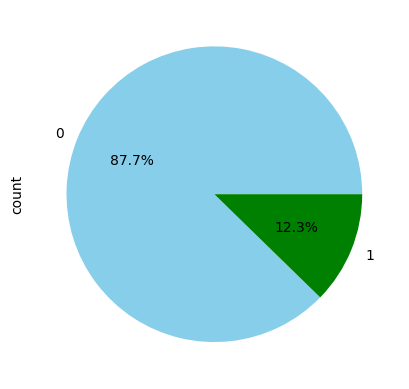

In [18]:
display_training_data_target_distribution(training_data_df)

In [19]:
training_data_df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

## Exploratory Data Analysis

Using EDA to find what the distribution of features is, how features relate to each other and how they relate to the target feature. Also finding correlation coefficients and using heatmaps to find what features are more important. 

In [20]:
training_data_df['Vehicle_Age'].value_counts(normalize=True)

Vehicle_Age
1-2 Year     0.520016
< 1 Year     0.438438
> 2 Years    0.041546
Name: proportion, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Age', ylabel='Density'>

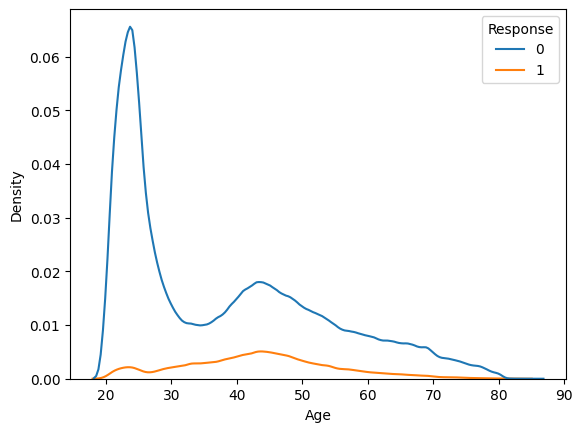

In [21]:
sns.kdeplot(data = training_data_df, x = 'Age', hue='Response')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Age', ylabel='Density'>

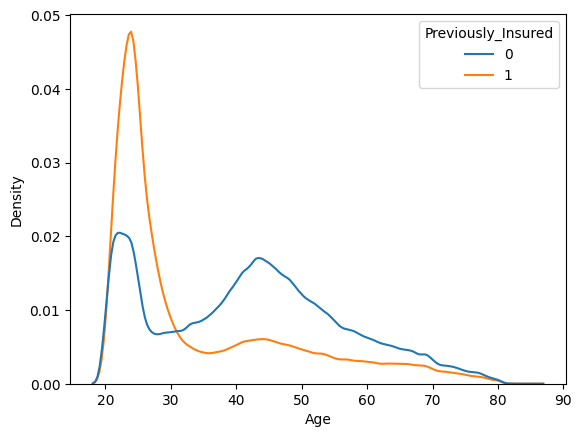

In [22]:
sns.kdeplot(data = training_data_df, x = 'Age', hue='Previously_Insured')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Response', ylabel='Age'>

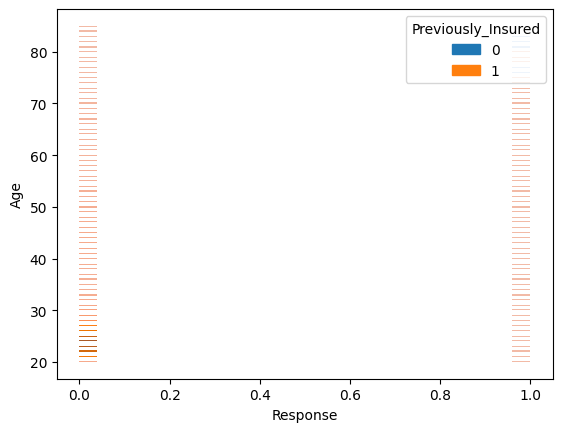

In [23]:
sns.histplot(data=training_data_df, x='Response', y='Age', hue='Previously_Insured')

In [24]:
def check_for_outliers(training_data_df: pd.DataFrame, col: str):
    sns.boxplot(data=training_data_df, x=col)

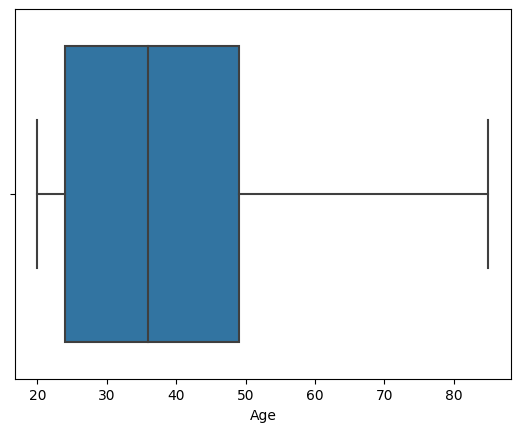

In [25]:
check_for_outliers(training_data_df, 'Age')

In [26]:
training_data_df['Annual_Premium'].describe()

count    1.150480e+07
mean     3.046137e+04
std      1.645475e+04
min      2.630000e+03
25%      2.527700e+04
50%      3.182400e+04
75%      3.945100e+04
max      5.401650e+05
Name: Annual_Premium, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

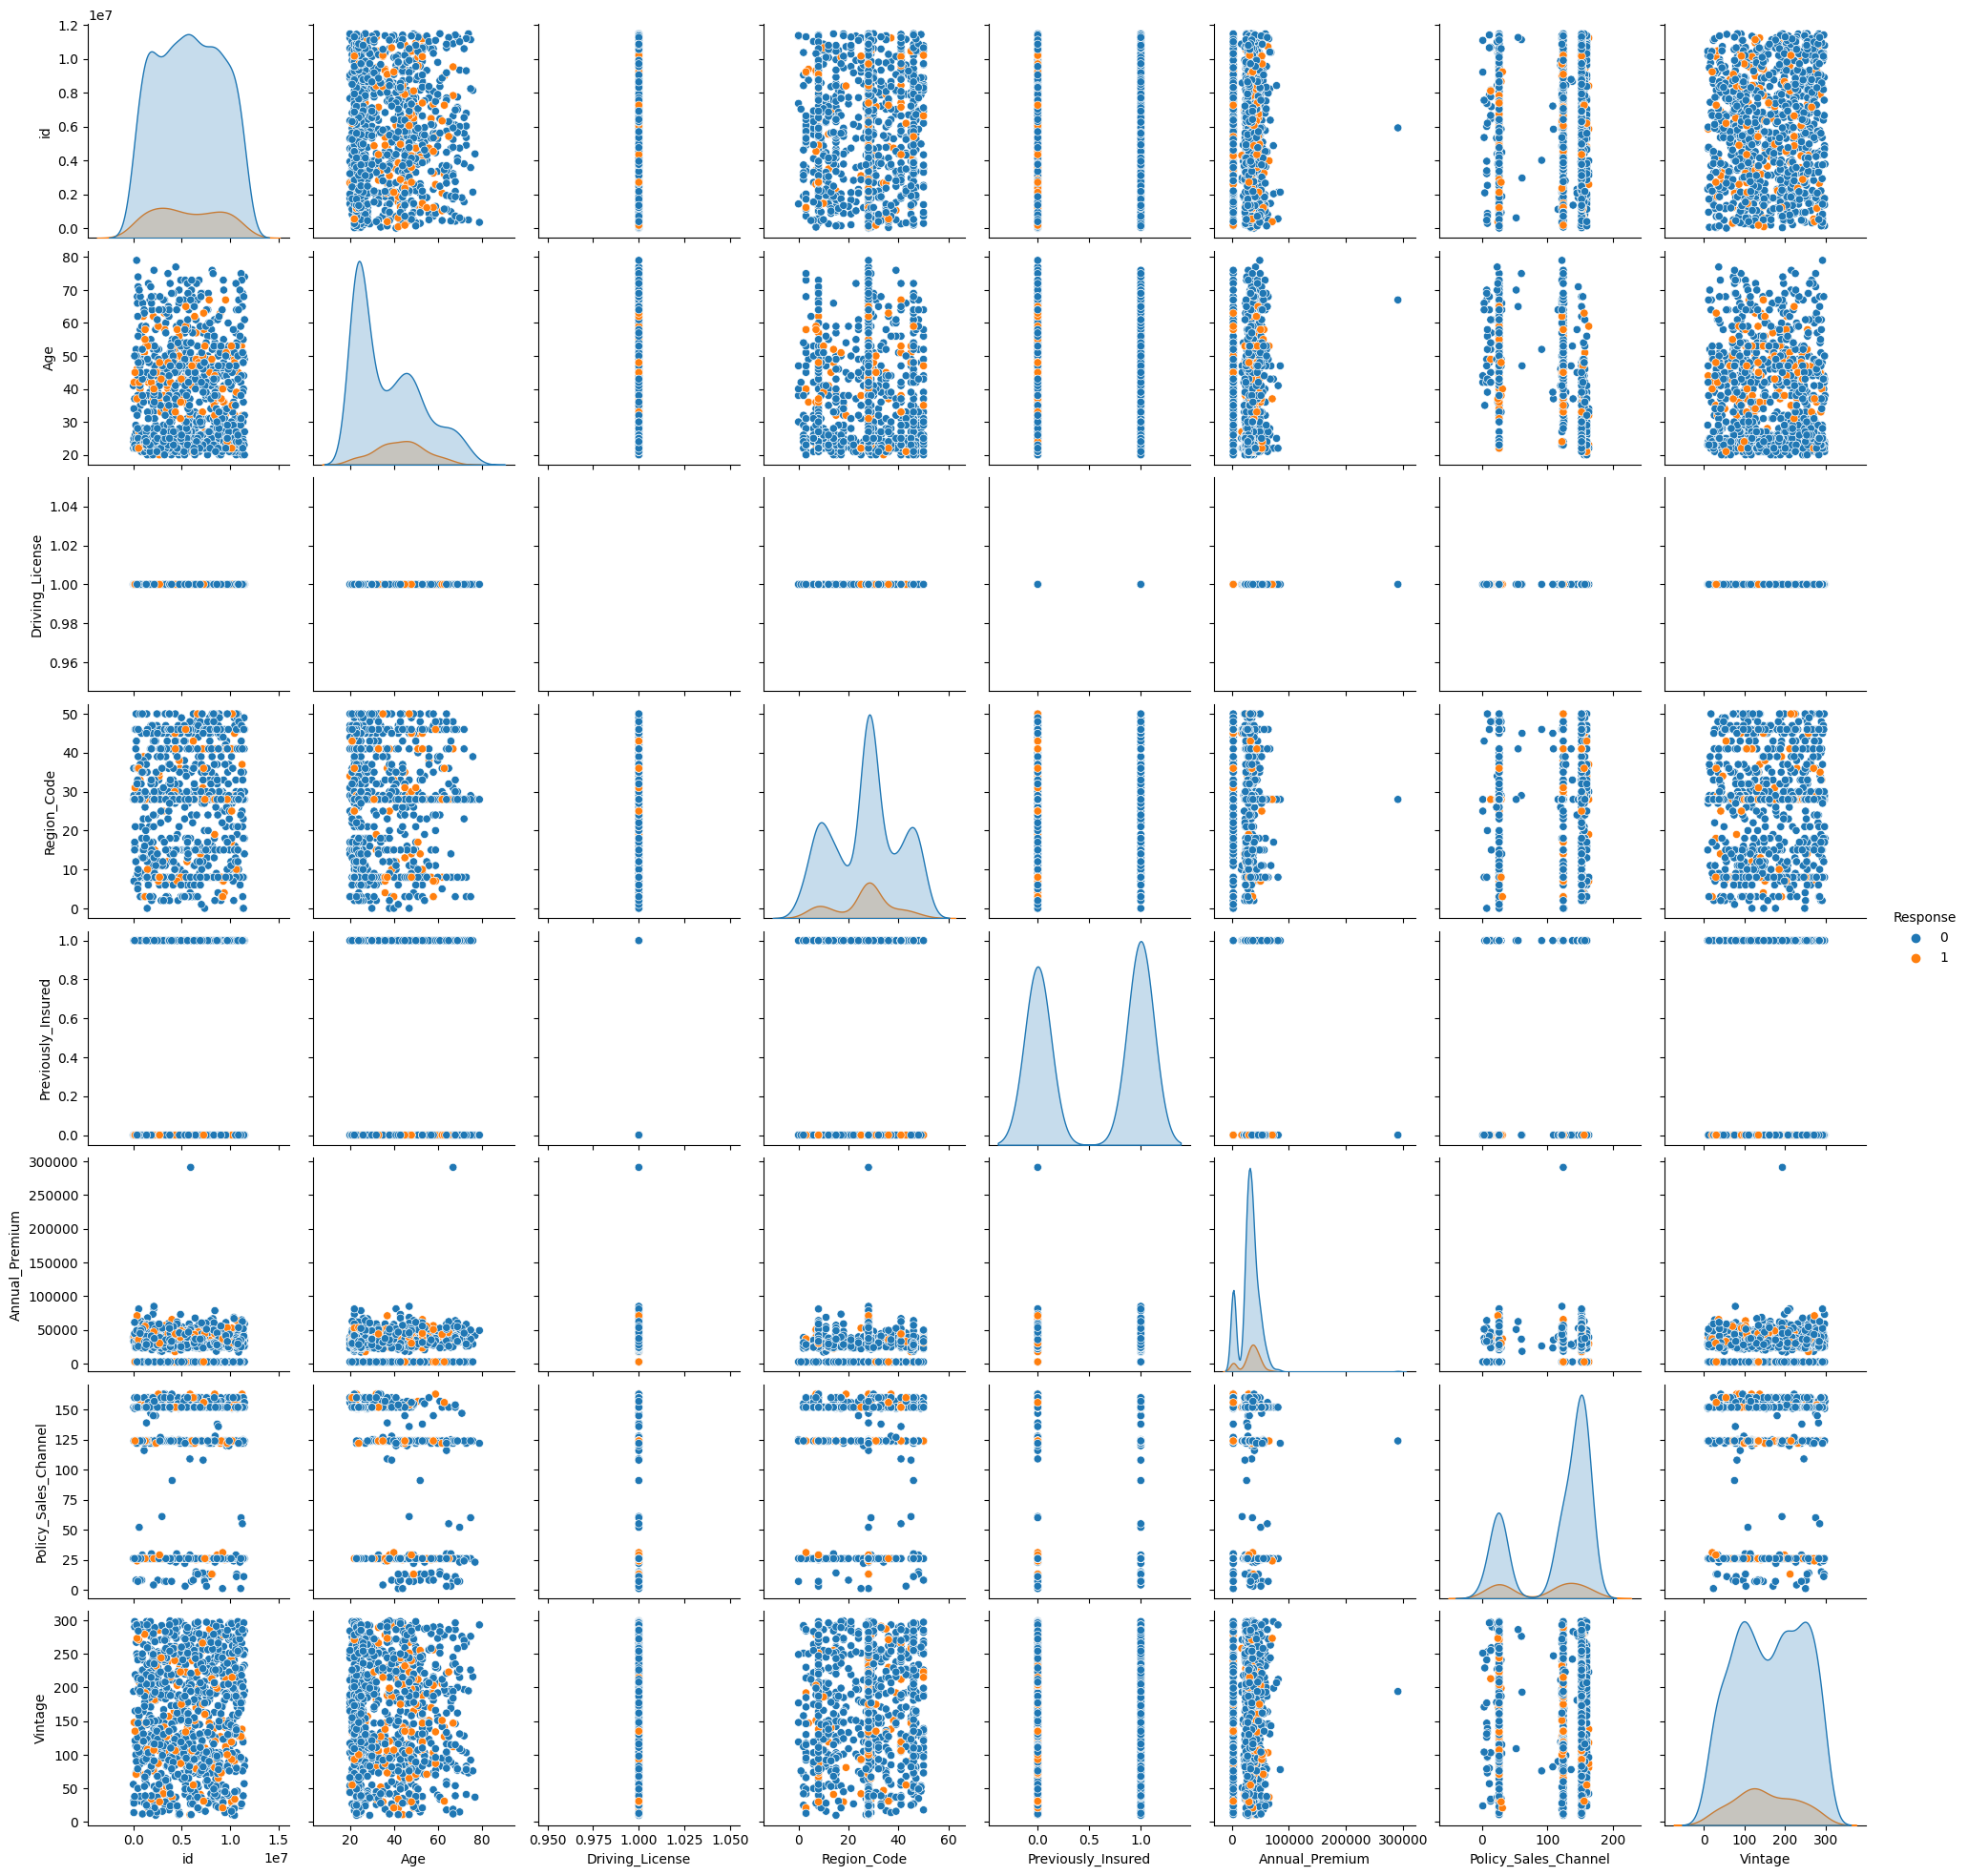

In [27]:
sns.pairplot(data=training_data_df.sample(1000), hue="Response")
plt.show()

<Axes: >

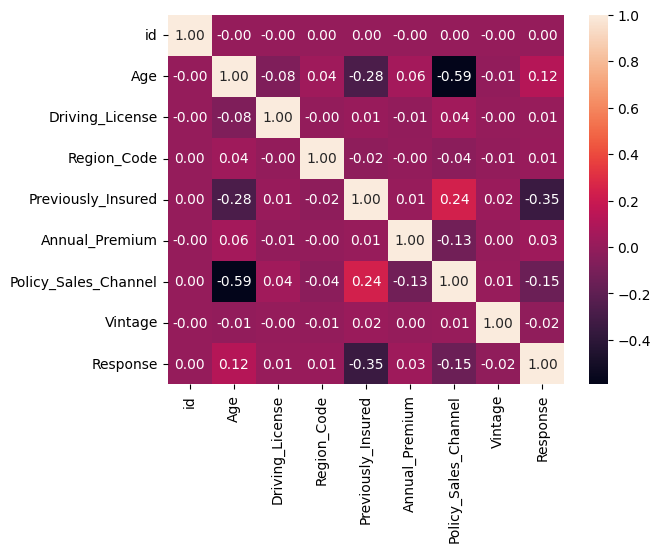

In [30]:
sns.heatmap(training_data_df.corr(numeric_only=True), annot=True, fmt=".2f")

## Preprocessing

Now using Label Encoder and dummy encoding to categorize the non-numerical features. Binary features will be dummy encoded.
Also, ids column is not essential.

In [34]:
def preprocess_data(training_data_df: pd.DataFrame):
    if "id" in training_data_df.columns:
        training_data_df = training_data_df.drop(axis=1, columns="id")
    
    training_data_df["Vehicle_Age"] = training_data_df["Vehicle_Age"].map({"< 1 Year": 1, "1-2 Year": 2, "> 2 Years": 3})
    
    label_encoder = LabelEncoder()
    for feature in training_data_df.columns:
        if training_data_df[feature].dtype == 'object' and training_data_df[feature].nunique() > 2:
            training_data_df[feature] = label_encoder.fit_transform(training_data_df[feature])
        if training_data_df[feature].dtype == 'object' and training_data_df[feature].nunique() <= 2:
            training_data_df[feature] = label_encoder.fit_transform(training_data_df[feature])

    return training_data_df

In [35]:
training_data_df = preprocess_data(training_data_df)

<Axes: >

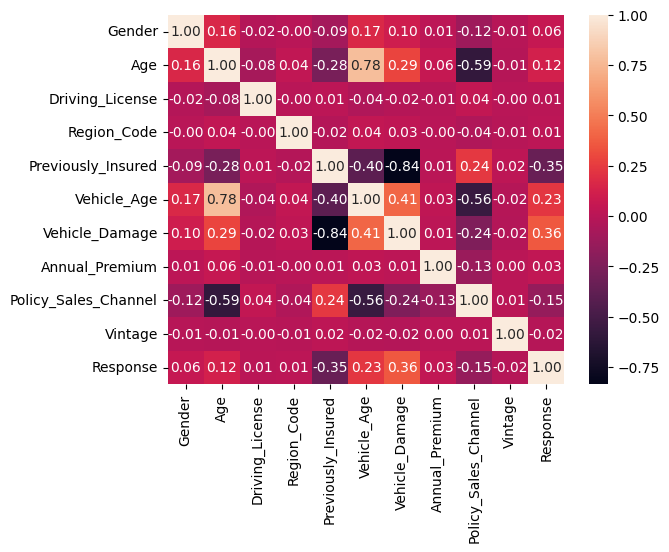

In [39]:
sns.heatmap(training_data_df.corr(), annot = True, fmt=".2f")

## Dropping Target and Splitting Dataset

In [40]:
def drop_target_feature(training_data_df: pd.DataFrame):
    target = training_data_df["Response"]
    training_data_df = training_data_df.drop(axis=1, columns="Response")
    
    return training_data_df, target

In [41]:
training_data_df, target = drop_target_feature(training_data_df)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(training_data_df, target, test_size=0.20, random_state = 2024)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9203838, 10), (2300960, 10), (9203838,), (2300960,))

## XGBoost ensemble model implementation

In [68]:
model = xgb.XGBClassifier(n_jobs=4, max_depth=10, min_samples_leaf=10, 
                         learning_rate=0.01, n_estimators=2000, eval_metric="auc", objective="binary:logistic")
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
#print(model)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:29:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


0.880228687156665


In [71]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [46]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix

In [72]:
roc_auc_score(y_test, predictions)

0.54612740073506

In [73]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94   2017603
           1       0.58      0.10      0.17    283357

    accuracy                           0.88   2300960
   macro avg       0.73      0.55      0.56   2300960
weighted avg       0.85      0.88      0.84   2300960



In [74]:
print(confusion_matrix(y_test, predictions))

[[1996228   21375]
 [ 254214   29143]]


## LightGBM model implementation

In [51]:
import lightgbm as lgb

In [52]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [53]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'learning_rate': 0.075,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'max_depth': 10
}


In [54]:
bst = lgb.train(
    params,
    train_data,
    num_boost_round=1308,             # Increased boost rounds
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(50)]
)

[LightGBM] [Info] Number of positive: 1131702, number of negative: 8072136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.010077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 9203838, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122960 -> initscore=-1.964695
[LightGBM] [Info] Start training from score -1.964695
Training until validation scores don't improve for 20 rounds
[50]	valid_0's auc: 0.872775
[100]	valid_0's auc: 0.876013
[150]	valid_0's auc: 0.877553
[200]	valid_0's auc: 0.878441
[250]	valid_0's auc: 0.878928
[300]	valid_0's auc: 0.879232
[350]	valid_0's auc: 0.879419
[400]	valid_0's auc: 0.879574
[450]	valid_0's auc: 0.879715
[500]	valid_0's auc: 0.879811
[550]	valid_0's auc: 0.879891
[600]	valid_0's auc: 0.879951
[650]	valid_0's auc: 0.880015
[700]	valid_0's auc: 0.880062
[750]	valid_0's auc: 

In [55]:
feature_importances = bst.feature_importance()

In [56]:
bst.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('auc', 0.880408024922507)])})

In [66]:
lgbm_feature_importance = pd.DataFrame(data={'Feature_Name': feature_names, 'Feature_Importance': feature_importances})

lgbm_feature_importance = lgbm_feature_importance.sort_values(by='Feature_Importance', ascending=False)

<BarContainer object of 10 artists>

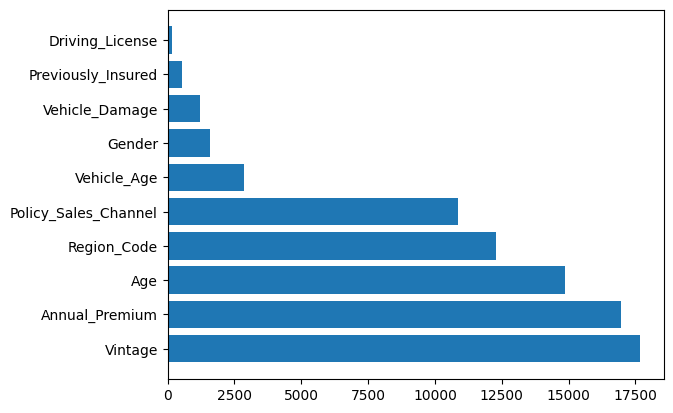

In [67]:
plt.barh(lgbm_feature_importance['Feature_Name'], lgbm_feature_importance['Feature_Importance'])

In [75]:
predictions = bst.predict(X_test)

In [76]:
1 in predictions


False

In [77]:
roc_auc_score(predictions, y_test)

ValueError: continuous format is not supported

Implement Grid Search
Handle Imbalance
SHAP